# **Grupo 14**

Trabalho realizado por:
* Beatriz Fernandes Oliveira A91640
* Catarina Martins Sá Quintas A91650

In [1]:
!pip install z3-solver

     |████████████████████████████████| 32.9 MB 81 kB/s 


# **Problema 1: Sistema de tráfego**

Nesta problema, iremos abordar um sistema de tráfego como um grafo orientado ligado. Sendo que os nodos representam pontos de acesso e os arcos donotam vias de comunicação só com um sentido. 

Primeiramente, é nos pedido que criemos uma função que gere aleatóriamente um grafo com 32 nodos. Em que um nodo tem um número aleatório de descendentes no intervalo de $\,1..3\,$ cujos destinos são distintos entre si do nodo origem.





##**Interpretação do problema**

Pela definição de Grafo, temos um grafo é dado por um tuplo constituido pelos vrtices e arestas, $(V, E)$.
* Um grafo é orientado se para cada arco v-w, o grafo não contém o arco  w-v.
* Um grafo orientado diz-se conectado se a substituição de todas as suas arestas direcionadas com arestas não direcionadas produz um grafo (não-direcionado) conectado.  

Temos de determinar um subgrafo $G' = (V, E')$ de $G$ e queremos minimizar $E'$, garatindo que o grafo permanece sempre ligado.
Assim sendo:
* Utilizamos a função 'all_simple_paths' para calcular o conjunto de caminhos sem ciclos de cada vértice de G (Paths).

* É necessário que uma aresta pertencente a $G$ também deve pertencer a $G'$.

* Para assegurar a existência desses caminhos sem ciclos, é necessário que a soma das multiplicações dos dados caminhos seja $\geq$ 1. Caso contrário, o  caminho será rejeitado.



In [2]:
from z3 import *
import networkx as nx
import random

[(0, 4), (0, 1), (0, 3), (1, 3), (2, 4), (2, 9), (2, 8), (3, 7), (3, 8), (4, 5), (4, 6), (4, 1), (5, 1), (5, 9), (6, 5), (7, 3), (7, 0), (8, 0), (8, 1), (9, 2), (9, 1), (9, 5)]
22


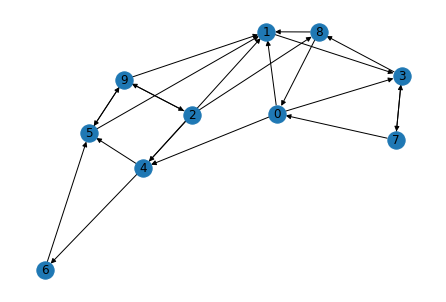

In [3]:
# criar grafo aleatorio 32 nodos 
#alínea a)

N = 10
k = 3
G = nx.DiGraph() 

vertices = list(range(0,N))
G.add_nodes_from(vertices)

# Assegurar o grau de pelo menos um vértice
for i in range(0, N):
  numbers = list(range(0,N))
  numbers.remove(i)
  edge_o = random.choice(numbers)
  G.add_edge(edge_o,i)

possible_edges = []

for i in range(0, N):  
  for j in range(0, N):
    possible_edges.append((i,j))


i = 0
total_possible_edges = N * N
while not nx.is_strongly_connected(G):
  random_edge_index = random.randint(0, total_possible_edges - 1)

  (edge_o,edge_d) = possible_edges.pop(random_edge_index)
  total_possible_edges = total_possible_edges - 1

  # Verifica se o out_degree é possível 
  if G.out_degree(edge_o) < 3:
    # Verifica se não faz self_loop
    if edge_o != edge_d:
      G.add_edge(edge_o,edge_d)
      i = i + 1

nx.draw(G, nx.spring_layout(G),with_labels=True)
print(G.edges)
print(len(G.edges))
























De seguida, foi nos pedido que determinassemos qual é o maior número de vias que podemos remover do grafo, criado anteriormente, sem que este deixe de ser ligado. 

$Objetivo$ 
* Determinar qual é o maior número de vias que são possíveis remover do grafo, mantendo o mesmo ligado. Ou seja, pretendemos **maximizar o número de vias a remover de um grafo**, de forma a que este continue ligado. Assim, temos que **minimizar o número de arestas**. 

$Requisitos$
* Os arcos só têm um sentido. Ou seja, considerando os seguintes arcos $n_1 \leadsto n_2$ e $n_2 \leadsto n_1$, estes têm de ser considerados distintos. 
* O grafo tem de ser ligado o que significa que entre cada par de nodos $ \langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
   

 Número de arestas iniciais: 22
 Arestas removidas são:  [(0, 1), (0, 3), (2, 4), (2, 9), (3, 8), (4, 5), (4, 1), (5, 1), (7, 3), (8, 0), (9, 1), (9, 5)]
 Número máximo de arestas removidas é:  12
 O número de arestas finais é:  10


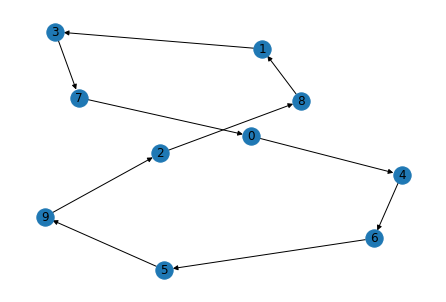

In [4]:
def all_simple_edges(G_in, source,target):
    paths = list(nx.all_simple_paths(G_in, source=source, target=target))
    edges = [[(paths[i][j-1], paths[i][j]) for j in range(1, len(paths[i]))] for i in range(len(paths))]
    return edges

print( " Número de arestas iniciais:" , len(G.edges()))

def path_edges(p):
  return [(p[i],p[i+1]) for i in range(len(p)-1)]
     
def subgrafo(grafo):
    solver = Optimize()
    B = {(i, j): Int(f'{i},{j}') for i in range(len(grafo.nodes())) for j in range(len(grafo.nodes()))}
    
    # Pertence ao grafo original
    for i in range(len(grafo.nodes())):
        for j in range(len(grafo.nodes())):
            if (i,j) in grafo.edges:
                A_ij = 1
            else:
                A_ij = 0 # caminho inacessivel
            solver.add(B[i,j] >= 0, B[i,j] <= A_ij)
            
    # Deve haver sempre um caminho entre cada par de nodos
    for i in grafo.nodes:
        for j in grafo.nodes:
            if i == j: continue
            S = all_simple_edges(grafo, i, j)
            #print(S)
            soma = sum([Product([B[w,z] for (w,z) in S_k]) for S_k in S])
            solver.add(soma >= 1)

    # Minimizar o número de arestas
    obj = solver.minimize(Sum([B[i,j] for i in range(len(grafo.nodes())) for j in range(len(grafo.nodes()))]))

    # Verificar a satisfabilidade
    if solver.check() == sat:
        m = solver.model()
        arestas_removidas = [(i,j) for i,j in grafo.edges if m[B[i,j]]==0]
        print(" Arestas removidas são: " , arestas_removidas)
        print (" Número máximo de arestas removidas é: ", len(arestas_removidas))
        r = nx.DiGraph.copy(grafo)
        r.remove_edges_from(arestas_removidas)
    else:
        print("No solution")
        r = None
    print(" O número de arestas finais é: ",  len(G.edges()) - len(arestas_removidas))    
    return r
  

graph = subgrafo(G)
#print(" O número de arestas finais é: ",  len(graph.edges)- arestas_removidas)
nx.draw(graph, with_labels=True, pos = nx.spring_layout(graph))






##**Exemplo:**
* Grafo orientado ligado com 32 nodos 

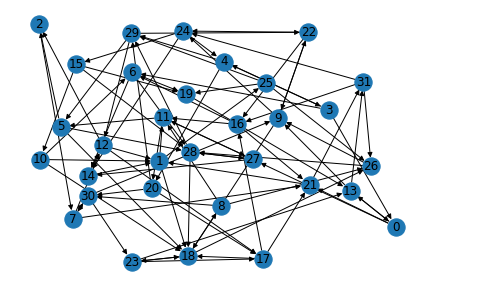








